# Finding blobs in 64x64 images using conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils
import os.path

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get data

Data reading function

In [2]:
shp=[15879,1,64,64,4]

good_data=utils.get_multichannel_image('/home/ubuntu/SAS_StemCell/good.tif_RotShift.tif', shp)[:,:,:,0:3]


In [98]:
shp=[49569,1,64,64,4]

bad_data=utils.get_multichannel_image('/home/ubuntu/SAS_StemCell/bad_subset.tif', shp)[:,:,:,0:3]

In [46]:
shp=[11055,1,64,64,4]

tricky_data=np.fromfile('/home/ubuntu/SAS_StemCell/Trickies_RotShift.raw', np.float32)
tricky_data=tricky_data.reshape([11055,4,64,64])
tricky_data=np.swapaxes(np.swapaxes(tricky_data.byteswap(),1,2),2,3)[:,:,:,0:3]


In [91]:
#bad_data=np.concatenate((tricky_data[0:2000,:,:,:], bad_data), axis=0)

In [4]:
shp=[8897,1,64,64,4]

true_test_data=utils.get_multichannel_image('/home/ubuntu/SAS_StemCell/test.tif', shp)[:,:,:,0:3]

Setup training set (training_*)

In [100]:
def get_data_and_truths(goods, bads, trickies):
    good_subset=good_data[goods,:,:,:]
    bad_subset=bad_data[bads, :,:,:]
    tricky_subset=tricky_data[trickies]
    training_list=np.concatenate((good_subset, bad_subset, tricky_subset), axis=0)
    training_truth=np.concatenate((np.ones([len(goods),1])*[1,0,0], np.ones([len(bads),1])*[0,0,1], np.ones([len(trickies),1])*[0,1,0]), axis=0)
    return (training_list, training_truth)

In [101]:
training_list,training_truth=get_data_and_truths(np.arange(0,60*201), np.arange(0,40000), np.arange(0,8000))

In [105]:
validation_list,validation_truth=get_data_and_truths(np.arange(60*201,70*201), np.arange(40000,47000), np.arange(8000,8500))

In [106]:
test_list,test_truth=get_data_and_truths(np.arange(70*201,78*201), np.arange(47000,49000), np.arange(8500,8800))

In [92]:
#training_goods=np.arange(0,60*201) #out of 79
#training_bads=np.arange(0,40000)
#training_trickies=np.arange(0,8000)

#training_good_subset=good_data[training_goods,:,:,:]
#training_bad_subset=bad_data[training_bads, :,:,:]
#training_trickies_subset=tricky_data[training_trickies, :,:,:]

#training_list=np.concatenate((training_good_subset, training_bad_subset, training_trickies), axis=0)
#training_truth=np.concatenate((np.ones([len(training_goods),1])*[1,0,0], np.ones([len(training_bads),1])*[0,0,1], np.ones([len(training_trickies),1])*[0,1,0]), axis=0)

#training_truth=np.concatenate((np.ones((training_good_subset.shape[0],1)), np.zeros((training_bad_subset.shape[0],1))), axis=0)
#training_truth=np.concatenate((training_truth,(1-training_truth)), axis=1)

Setup validation set (validation_*)

In [93]:
#validation_goods=np.arange(60*201,70*201) #out of 79
#validation_bads=np.arange(40000,47000)
#validation_list=np.concatenate((good_data[validation_goods,:,:,:], bad_data[validation_bads, :,:,:]), axis=0)
#validation_truth=np.concatenate((np.ones((len(validation_goods),1)), np.zeros((len(validation_bads),1))), axis=0)
#validation_good_subset=good_data[validation_goods,:,:,:]
#validation_bad_subset=bad_data[validation_bads, :,:,:]
#validation_list=np.concatenate((validation_good_subset, validation_bad_subset), axis=0)
#validation_truth=np.concatenate((np.ones((validation_good_subset.shape[0],1)), np.zeros((validation_bad_subset.shape[0],1))), axis=0)
#validation_truth=np.concatenate((validation_truth,(1-validation_truth)), axis=1)

In [94]:
#test_goods=np.arange(70*201,78*201) #out of 79
#test_bads=np.arange(47000,49000)
#test_list=np.concatenate((good_data[test_goods,:,:,:], bad_data[test_bads, :,:,:]), axis=0)
#test_truth=np.concatenate((np.ones((len(test_goods),1)), np.zeros((len(test_bads),1))), axis=0)
#test_good_subset=good_data[test_goods,:,:,:]
#test_bad_subset=bad_data[test_bads, :,:,:]
#test_list=np.concatenate((test_good_subset, test_bad_subset), axis=0)
#test_truth=np.concatenate((np.ones((test_good_subset.shape[0],1)), np.zeros((test_bad_subset.shape[0],1))), axis=0)
#test_truth=np.concatenate((test_truth,(1-test_truth)), axis=1)

# Design network

In [161]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64,3])
y=tf.placeholder(dtype=tf.float32, shape=[None, 3])

base_scaler=8

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(x, base_scaler, [3,3], padding='SAME'))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

flattened=tf.layers.flatten(D2)
#I don't think this layer is actually necessary
#dense1=tf.layers.dropout(tf.layers.dense(flattened, 1024),0.5)
dense2=tf.layers.dense(flattened, 128)
dense3=tf.layers.dense(dense2, 16)
logits=tf.layers.dense(dense3, 3)

loss = tf.losses.softmax_cross_entropy(y, logits)

probs=tf.nn.softmax(logits)


train_op=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


# Training on easy set

In [163]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(20000):
    idx=np.random.choice(training_list.shape[0], replace=False, size=[2000])
    cur_train=training_list[idx,:,:,:]
    cur_truth=training_truth[idx,:]
    _,results, losses=sess.run([train_op, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%30==0):
        print(i)
        print("Training loss: ",losses)
        idx=np.random.choice(validation_list.shape[0], replace=False, size=[7000])
        sub_validation_data=validation_list[idx, :,:,:]
        sub_validation_truth=validation_truth[idx, :]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        print("Validation loss: ",losses)
        #f,axes=plt.subplots(2,2, figsize=(8,8))
        #ix=np.random.randint(0,100)
        #axes[0,0].imshow(sub_validation_data[ix,:,:,0])
        #axes[0,1].imshow(a[ix,:,:,1])
        #axes[1,0].imshow(a[ix,:,:,2])
        #axes[1,1].imshow(a[ix,:,:,3])
        #print([results[ix,0], sub_validation_truth[ix,0]])
        #plt.show()

0
Training loss:  8.803536
Validation loss:  5.4588
30
Training loss:  0.6995931
Validation loss:  1.0758485
60
Training loss:  0.3783314
Validation loss:  0.50155085
90
Training loss:  0.20553955
Validation loss:  0.3084199
120
Training loss:  0.14895634
Validation loss:  0.2709711
150
Training loss:  0.15724683
Validation loss:  0.19640656
180
Training loss:  0.11811746
Validation loss:  0.18602093
210
Training loss:  0.07510288
Validation loss:  0.18393233


KeyboardInterrupt: 

# Look at validation data

In [164]:
idx=np.random.choice(validation_list.shape[0], replace=False, size=[1000])
sub_validation_data=validation_list[idx, :,:,:]
sub_validation_truth=validation_truth[idx, :]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
losses

0.26547533

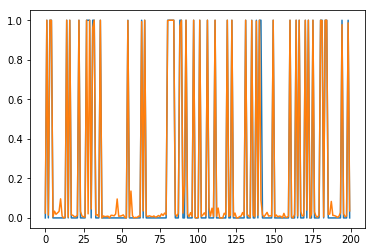

In [165]:
plt.plot(sub_validation_truth[0:200,0])
plt.plot(results[0:200,0])

In [166]:
bads=np.argwhere(np.round(results[:,0])!=sub_validation_truth[:,0])
bads

array([[ 28],
       [141],
       [210],
       [219],
       [227],
       [251],
       [291],
       [315],
       [319],
       [339],
       [372],
       [397],
       [414],
       [415],
       [431],
       [433],
       [435],
       [496],
       [596],
       [606],
       [704],
       [720],
       [755],
       [764],
       [781],
       [870],
       [890]])

[1.0, 0.020615024]


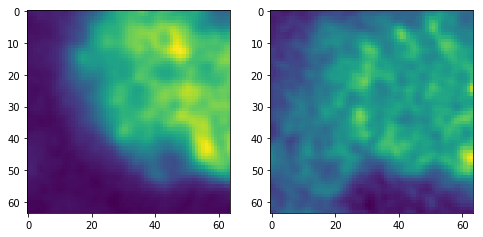

[1.0, 0.090041876]


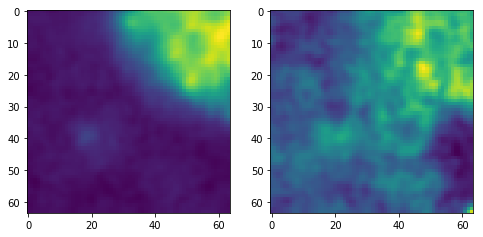

[1.0, 0.44500563]


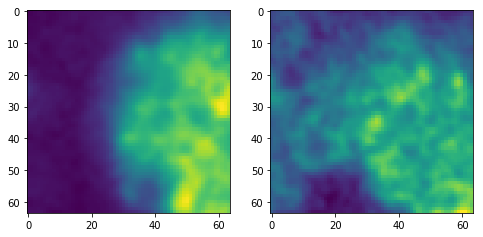

[1.0, 0.0026439764]


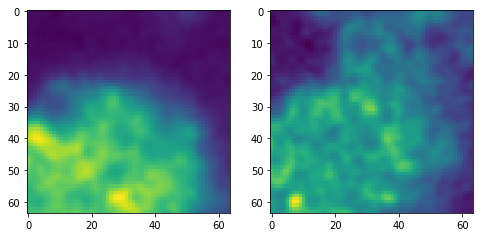

[0.0, 0.9484401]


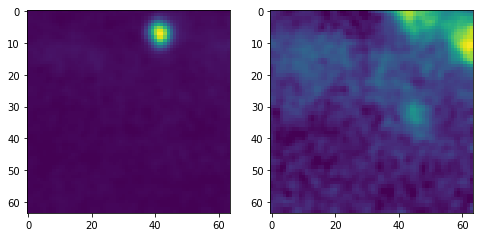

[1.0, 0.020398589]


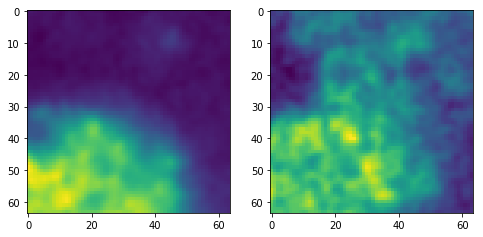

[0.0, 0.999956]


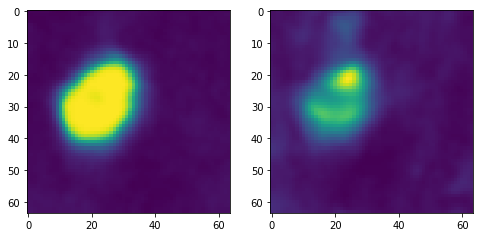

[1.0, 0.0023759704]


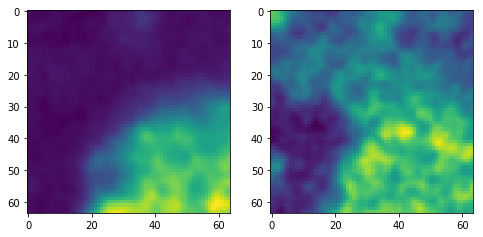

[0.0, 1.0]


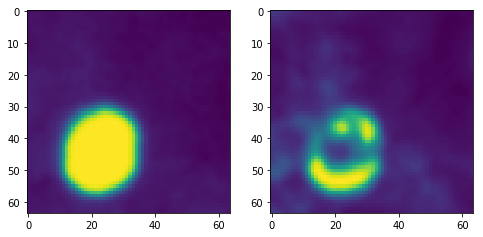

[1.0, 0.00011469735]


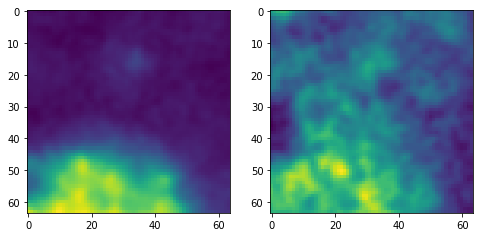

[0.0, 0.99912244]


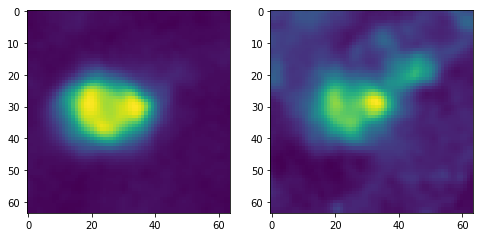

[0.0, 0.991916]


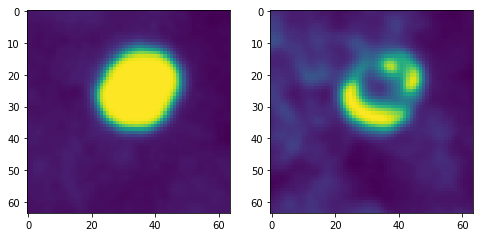

[1.0, 0.0012541845]


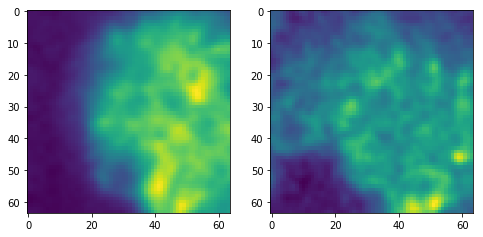

[1.0, 0.009160423]


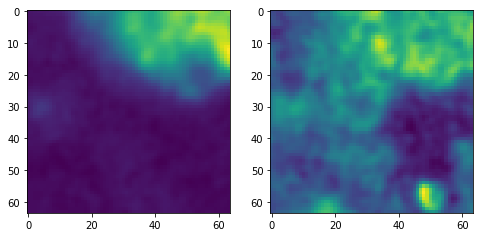

[1.0, 0.0003096671]


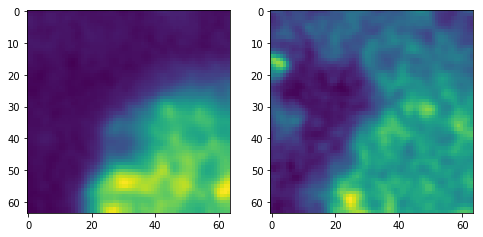

[0.0, 0.543584]


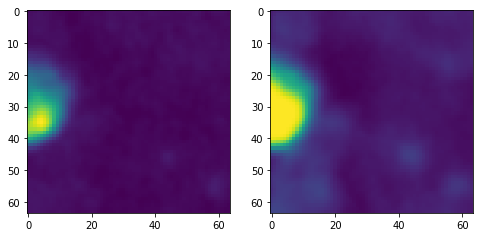

[1.0, 0.01372634]


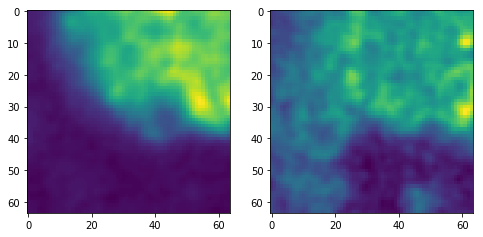

[0.0, 0.8304086]


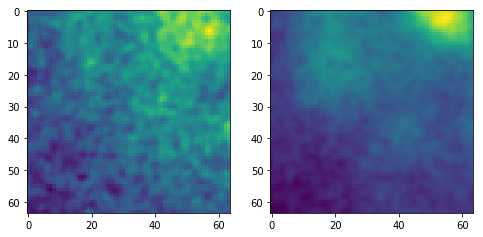

[1.0, 0.09943256]


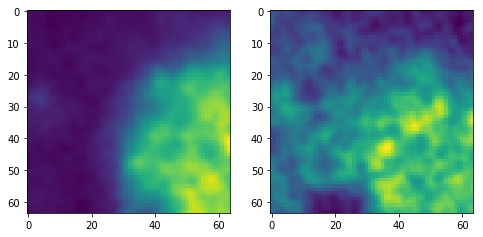

[1.0, 0.027277214]


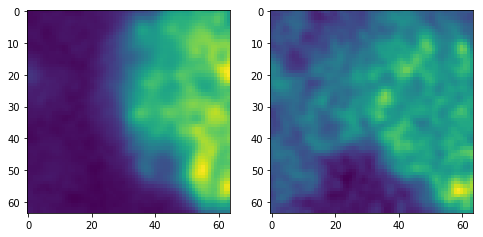

[0.0, 0.9979145]


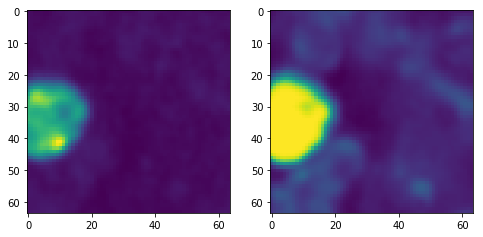

[1.0, 4.39042e-06]


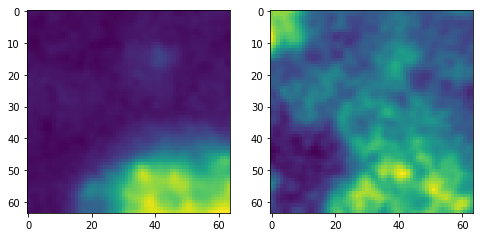

[1.0, 4.3475472e-07]


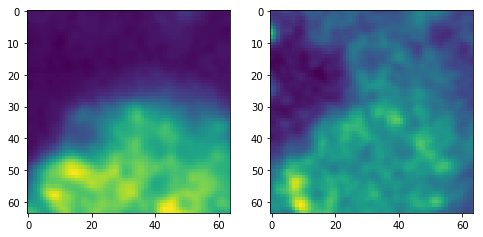

[1.0, 0.29624754]


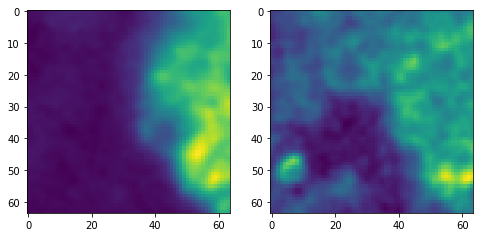

[1.0, 0.00055739156]


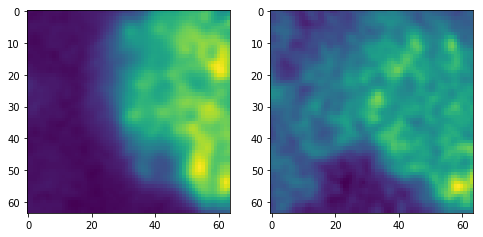

[1.0, 0.00051392784]


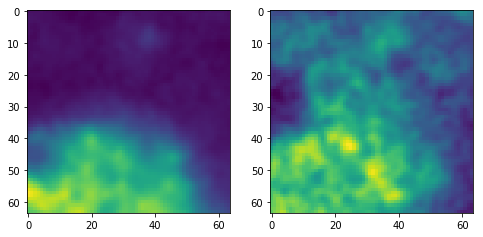

[1.0, 0.0008413997]


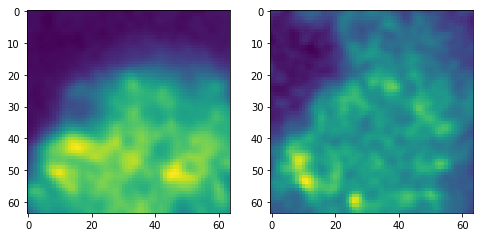

In [167]:
for i in bads:
    ix=i[0]
    f,axes=plt.subplots(1,2, figsize=(8,8))
    axes[0].imshow(sub_validation_data[ix,:,:,0])
    #axes[0,1].imshow(sub_validation_data[ix,:,:,1])
    axes[1].imshow(sub_validation_data[ix,:,:,2])
    #axes[1,1].imshow(sub_validation_data[ix,:,:,3])
    print([sub_validation_truth[ix,0], results[ix,0]])
    plt.show()

# Look at whole image bone 2 081516

In [77]:
sub_validation_data=true_test_data[0:8000, :,:,:]
sub_validation_truth=validation_truth[0:8000, :]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})

In [78]:
np.argwhere(np.round(results[:,0]))

array([[ 719],
       [ 720],
       [ 934],
       [ 935],
       [ 936],
       [ 937],
       [ 943],
       [ 944],
       [2238],
       [2239],
       [2664],
       [2665],
       [2666],
       [2669],
       [2670],
       [2671],
       [2672],
       [2673],
       [2674],
       [2675],
       [2676],
       [2677],
       [2678],
       [2679],
       [2680],
       [2887],
       [2888],
       [2893],
       [2894],
       [2895],
       [2896],
       [2897],
       [3096],
       [3098],
       [3099],
       [3105],
       [3528],
       [3529],
       [3530],
       [3531],
       [3532],
       [3533],
       [3534],
       [3535],
       [3536],
       [3537],
       [3538],
       [3539],
       [3540],
       [3541],
       [3738],
       [3747],
       [3748],
       [3749],
       [3755],
       [3756],
       [3757],
       [3758],
       [3836],
       [3837],
       [3838],
       [3839],
       [3964],
       [3965],
       [3966],
       [3967],
       [39

In [79]:
len(np.argwhere(np.round(results[:,0])))

89

[0.0, 0.9999411]

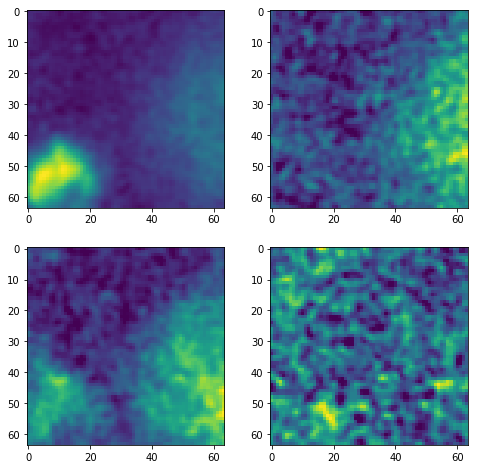

In [178]:
ix=888
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]

# Look at whole image bone 2 13 081516

In [181]:
shp=[64821,1,64,64,4]
true_test2_data=np.fromfile('/home/ubuntu/SAS_StemCell/test6.raw', np.float32)
true_test2_data=true_test2_data.reshape([64821,4,64,64])
true_test2_data=np.swapaxes(np.swapaxes(true_test2_data.byteswap(),1,2),2,3)[:,:,:,0:3]

In [182]:
num_images=true_test2_data.shape[0]
output=np.zeros(num_images)
process_batch_size=8000

In [185]:
for t in range(0,num_images,process_batch_size):
    endrng=np.min((t+process_batch_size,num_images))
    sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
    sub_validation_truth=validation_truth[0:sub_validation_data.shape[0], :]
    results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
    output[t:(t+process_batch_size)]=results[:,1]
np.sum(output>0.5)

1105

In [186]:
np.savetxt('/home/ubuntu/SAS_StemCell/test6b.txt', output)

[0.0, 0.9999254]

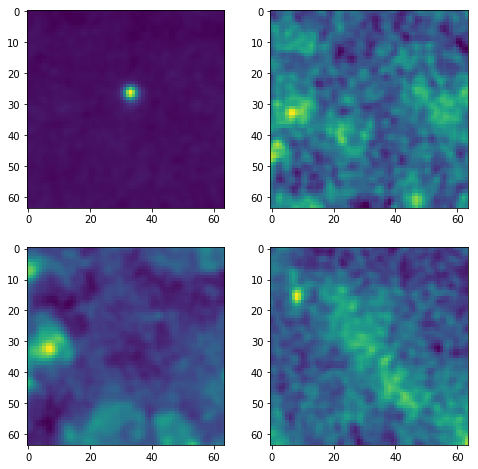

In [58]:
ix=7067
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]

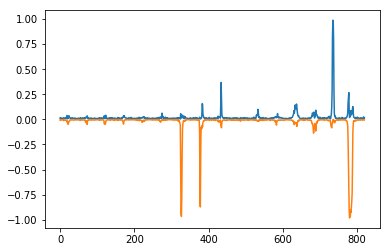

In [173]:
plt.plot(results[:,0]-0*results[:,1])
plt.plot(-results[:,1])



In [133]:
np.max(np.sum(results, axis=1))

1.0000001

In [145]:
saver=tf.train.Saver()

In [180]:
saver.save(sess, "/tmp/modelv2.ckpt")

'/tmp/modelv2.ckpt'